# Demo Notebook

This notebook will show you how to get started with NFL fantasy data.

We will import these helpful modules:

- **DuckDB:** an analytical database that contains all our data.
- **Pandas:** a module for working with tabular data.
- **Seaborn:** one of our modules for visualizing data.
- **Matplotlib:** one of our modules for visualizing data.

In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Accessing Data

Our data should already be loaded into DuckDB. We can access DuckDB through both SQL and Python code.

We will start with a query to see which tables are available.

The DuckDB Python module allows us to run queries on the database and view the results as either text or as Pandas dataframes. Below are examples of the same query in both formats.

In [2]:
DATABASE = "../database.db"
con = duckdb.connect(DATABASE, read_only=True)

In [3]:
query = """
SHOW TABLES;
"""
con.sql(query)

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ league_roster    │
│ league_user      │
│ player           │
│ player_week_data │
└──────────────────┘

In [4]:
con.execute(query).fetchdf()

,name
0,league_roster
1,league_user
2,player
3,player_week_data


We can learn more about each table using the `DESCRIBE` SQL command.

Then, we can `SELECT` from the table to see what the data looks like.

In [5]:
con.sql("DESCRIBE player_week_data;")

┌──────────────────────────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬───────┐
│                   column_name                    │ column_type │  null   │   key   │ default │ extra │
│                     varchar                      │   varchar   │ varchar │ varchar │ varchar │ int32 │
├──────────────────────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼───────┤
│ week                                             │ BIGINT      │ YES     │ NULL    │ NULL    │  NULL │
│ team                                             │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ sport                                            │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ season_type                                      │ VARCHAR     │ YES     │ NULL    │ NULL    │  NULL │
│ season                                           │ BIGINT      │ YES     │ NULL    │ NULL    │  NULL │
│ player_id                                        │ VA

In [6]:
con.execute("""
SELECT
    season,
    week,
    team,
    opponent,
    player_name,
    player_id,
    position,
    category,
    company,
    standard_scoring_fantasy_points AS fantasy_points,
    passing_yards,
    rushing_yards,
    receiving_yards,
FROM player_week_data
WHERE season = 2022 AND week = 1
ORDER BY fantasy_points DESC
LIMIT 5;
""").fetchdf()

,season,week,team,opponent,player_name,player_id,position,category,company,fantasy_points,passing_yards,rushing_yards,receiving_yards
0,2022,1,KC,ARI,Patrick Mahomes,4046,QB,stat,sportradar,33.90,360.0,5.0,0.0
1,2022,1,BUF,LAR,Josh Allen,4984,QB,stat,sportradar,33.48,297.0,56.0,0.0
2,2022,1,MIN,GB,Justin Jefferson,6794,WR,stat,sportradar,30.40,0.0,0.0,184.0
3,2022,1,WAS,JAX,Carson Wentz,3161,QB,stat,sportradar,29.72,313.0,12.0,0.0
4,2022,1,PIT,CIN,Pittsburgh Steelers,PIT,DEF,stat,sportradar,27.00,0.0,0.0,0.0


Here is some more information that is not obvious from the table description:

- This table has over 200 columns, most of them are metrics
- Read `workflows/metadata.py` to see all the available metrics
- All this data is from Sleeper, which retrieves it from a company like `sportradar` or `rotowire`
- Each row in the table is the data for one player and one week, either statistics or projections
- Use the `category` column to filter to either `stat` or `proj` depending on which data you want

In [7]:
con.execute("""
SELECT
    season,
    week,
    team,
    opponent,
    player_name,
    player_id,
    position,
    category,
    company,
    standard_scoring_fantasy_points AS fantasy_points,
    passing_yards,
    rushing_yards,
    receiving_yards,
FROM player_week_data
WHERE season = 2022 AND week = 1 AND category = 'proj'
ORDER BY fantasy_points DESC
LIMIT 5;
""").fetchdf()

,season,week,team,opponent,player_name,player_id,position,category,company,fantasy_points,passing_yards,rushing_yards,receiving_yards
0,2022,1,BUF,LAR,Josh Allen,4984,QB,proj,rotowire,26.29,278.52,38.91,0.0
1,2022,1,LAC,LV,Justin Herbert,6797,QB,proj,rotowire,25.94,310.38,22.05,0.0
2,2022,1,KC,ARI,Patrick Mahomes,4046,QB,proj,rotowire,25.68,310.31,21.81,0.0
3,2022,1,BAL,NYJ,Lamar Jackson,4881,QB,proj,rotowire,24.70,247.67,57.46,0.0
4,2022,1,PHI,DET,Jalen Hurts,6904,QB,proj,rotowire,24.40,250.78,47.72,0.0


## Example

As an example, we will compare the projected and actual fantasy points of top players from the 2022 season.

We will use DuckDB SQL and Pandas to retrieve the data, then use Seaborn and Matplotlib to visualize it.

In [8]:
df_actual_vs_projected = con.execute("""
WITH

actual AS (
    SELECT
        player_id,
        position,
        max(player_name) AS player_name,
        SUM(standard_scoring_fantasy_points) AS fantasy_points,
    FROM player_week_data
    WHERE season = 2022 AND category = 'stat'
    GROUP BY player_id, position
),

projected AS (
    SELECT
        player_id,
        position,
        max(player_name) AS player_name,
        SUM(standard_scoring_fantasy_points) AS fantasy_points,
    FROM player_week_data
    WHERE season = 2022 AND category = 'proj'
    GROUP BY player_id, position
),

result AS (
    SELECT
        actual.* EXCLUDE(fantasy_points),
        actual.fantasy_points AS actual_points,
        projected.fantasy_points AS projected_points,
    FROM actual
    LEFT JOIN projected
        ON actual.player_id = projected.player_id
        AND actual.position = projected.position
    ORDER BY actual_points DESC
)

SELECT *
FROM result
LIMIT 10
;
""").fetchdf()
df_actual_vs_projected

,player_id,position,player_name,actual_points,projected_points
0,4046,QB,Patrick Mahomes,412.42,415.69
1,4984,QB,Josh Allen,386.48,441.65
2,6904,QB,Jalen Hurts,373.58,370.65
3,6770,QB,Joe Burrow,354.38,370.00
4,7591,QB,Justin Fields,303.98,303.00
5,1373,QB,Geno Smith,298.26,316.57
6,7523,QB,Trevor Lawrence,293.44,325.93
7,5870,QB,Daniel Jones,293.00,310.27
8,1166,QB,Kirk Cousins,291.58,330.44
9,3163,QB,Jared Goff,279.86,320.52


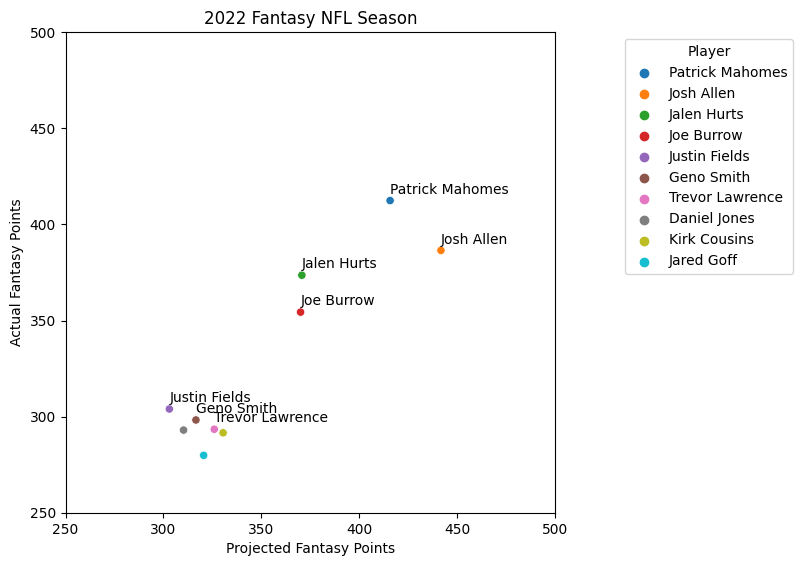

In [9]:
x_column = "projected_points"
y_column = "actual_points"
point_name = "player_name"

sns.scatterplot(
    data=df_actual_vs_projected,
    x=x_column,
    y=y_column,
    hue=point_name
)

for i, row in df_actual_vs_projected.iterrows():
    if i > 6:
        continue
    plt.annotate(
        row[point_name],
        (row[x_column], row[y_column]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="left"
    )

plt.xlim(250, 500)
plt.ylim(250, 500)
plt.xlabel("Projected Fantasy Points")
plt.ylabel("Actual Fantasy Points")
plt.title("2022 Fantasy NFL Season")
plt.legend(title="Player", loc="upper right", bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.gcf().set_size_inches(10, 6)
plt.show()